### **Modelo Metaheurístico de Ruteo con Capacidades – Etapa 3 (Caso 2)**

#### **Enfoque General**
La Etapa 3 del proyecto implementa una solución alternativa al modelo exacto del CVRP mediante una metaheurística evolutiva, específicamente un Algoritmo Genético (GA). Este enfoque permite abordar problemas de mayor escala con tiempos de ejecución más manejables, sin necesidad de depender de solvers comerciales o formulaciones algebraicas complejas.


#### **Representación y Estructura del Modelo**

Estructura de la Solución:
- Cada solución (individuo) representa una permutación de clientes a visitar.
- Se repara la solución dividiéndola en rutas factibles según la capacidad de los vehículos.

Componentes del Algoritmo Genético:
- Inicialización: generación aleatoria de individuos.
- Evaluación: cálculo del costo total de la solución, considerando distancias y demandas.
- Cruce: operador Order Crossover (OX) que preserva subsecuencias válidas.
- Mutación: intercambio aleatorio de dos nodos en una ruta.
- Selección: torneo binario, con elitismo para conservar la mejor solución por generación.
- Reparación: función que divide una secuencia global en rutas viables según la capacidad del camión.


#### Función de Evaluación
Cada individuo se evalúa en función del costo total, compuesto por:

1. Distancia total recorrida por cada ruta (ida y vuelta al depósito).
2. Cumplimiento de restricciones de capacidad, garantizado por la función de reparación.

#### Resultados Visuales y Análisis

La solución obtenida fue representada sobre un mapa interactivo utilizando folium, en el cual:

- Cada vehículo tiene un color distinto.
- Las rutas comienzan y terminan en el depósito.
- Se visualiza la cobertura geográfica agrupada por regiones.



In [1]:
from google.colab import files
import io
import pandas as pd

print("Selecciona depots.csv, stations.csv, clients.csv y vehicles.csv")
uploaded = files.upload()

dfs = {}
for key, val in uploaded.items():
    kl = key.lower()
    if 'depot'   in kl:
        dfs['depots']   = pd.read_csv(io.BytesIO(val))
    elif 'station' in kl:
        dfs['stations'] = pd.read_csv(io.BytesIO(val))
    elif 'client'  in kl:
        dfs['clients']  = pd.read_csv(io.BytesIO(val))
    elif 'vehicle' in kl:
        dfs['vehicles'] = pd.read_csv(io.BytesIO(val))
    else:
        print("Archivo no reconocido, ignorando:", key)

depots_df   = dfs['depots']
stations_df = dfs['stations']
clients_df  = dfs['clients']
vehicles_df = dfs['vehicles']

Selecciona depots.csv, stations.csv, clients.csv y vehicles.csv


Saving clients.csv to clients.csv
Saving depots.csv to depots.csv
Saving stations.csv to stations.csv
Saving vehicles.csv to vehicles.csv


In [2]:
import pandas as pd
import math
from pyomo.environ import SolverFactory
#from google.colab import drive

# Coordenadas de municipios
coordenadas = {
    'Bogotá':       (4.60971,  -74.08175),
    'Medellín':     (6.25184,  -75.56359),
    'Cali':         (3.43722,  -76.52250),
    'Cartagena':    (10.39972, -75.51444),
    'Cúcuta':       (7.89391,  -72.50782),
    'Bucaramanga':  (7.12539,  -73.11980),
    'Pereira':      (4.81333,  -75.69611),
    'Santa Marta':  (11.24079, -74.19904),
    'Ibagué':       (4.43889,  -75.23222),
    'Manizales':    (5.06889,  -75.51738),
    'Neiva':        (2.92730,  -75.28189),
    'Barranquilla': (10.96854, -74.78132),
    'Villavicencio':(4.14200,  -73.62664),
    'Armenia':      (4.53389,  -75.68111),
}

# Mapear lat/lon a clients_df
clients_df['Latitude']  = clients_df['City/Municipality'].map(lambda c: coordenadas[c][0])
clients_df['Longitude'] = clients_df['City/Municipality'].map(lambda c: coordenadas[c][1])

# Calcular distancias Haversine
def haversine(lat1, lon1, lat2, lon2):
    R = 6371
    phi1, phi2 = math.radians(lat1), math.radians(lat2)
    dphi = math.radians(lat2 - lat1)
    dlambda = math.radians(lon2 - lon1)
    a = math.sin(dphi/2)**2 + math.cos(phi1)*math.cos(phi2)*math.sin(dlambda/2)**2
    return 2 * R * math.asin(math.sqrt(a))

In [3]:
import pandas as pd
import numpy as np
from math import radians, cos, sin, asin, sqrt

# --- Extraer coordenadas del depósito ---
depot = depots_df.iloc[0]
depot_coord = (depot['Latitude'], depot['Longitude'])

# --- Extraer coordenadas y demandas de clientes ---
clients_df['coords'] = list(zip(clients_df['Latitude'], clients_df['Longitude']))
client_coords = clients_df['coords'].tolist()
client_ids = clients_df['ClientID'].tolist()
client_demands = clients_df['Demand'].tolist()

# --- Capacidad del vehículo (usamos el primero) ---
vehicle_capacity = vehicles_df.iloc[0]['Capacity']


# --- Matriz de distancias ---
all_coords = [depot_coord] + client_coords
n = len(all_coords)
distance_matrix = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        distance_matrix[i][j] = haversine(*all_coords[i], *all_coords[j])

In [4]:
import random

# --- Total de clientes (sin incluir el depósito) ---
num_clients = len(client_ids)
num_vehicles = 1000  # puedes ajustar esto

# --- Función para generar una solución factible inicial ---
def generar_ruta_inicial():
    indices = list(range(1, num_clients + 1))  # del 1 al N (clientes)
    random.shuffle(indices)

    rutas = []
    ruta_actual = []
    carga_actual = 0

    for idx in indices:
        demanda = client_demands[idx - 1]  # -1 porque cliente 1 está en posición 0
        if carga_actual + demanda <= vehicle_capacity:
            ruta_actual.append(idx)
            carga_actual += demanda
        else:
            rutas.append(ruta_actual)
            ruta_actual = [idx]
            carga_actual = demanda
    if ruta_actual:
        rutas.append(ruta_actual)

    return rutas

# --- Función para crear población inicial ---
def crear_poblacion_inicial(tamano_poblacion):
    return [generar_ruta_inicial() for _ in range(tamano_poblacion)]

# --- Crear población inicial ---
tamano_poblacion = 500
poblacion = crear_poblacion_inicial(tamano_poblacion)


In [5]:
# --- Función para evaluar una solución ---
def evaluar_solucion(rutas):
    total_distancia = 0
    penalizacion = 0

    for ruta in rutas:
        if not ruta:
            continue

        carga = sum([client_demands[i - 1] for i in ruta])
        if carga > vehicle_capacity:
            penalizacion += 1000 * (carga - vehicle_capacity)

        # Distancia desde el depósito al primer cliente
        distancia = distance_matrix[0][ruta[0]]

        # Distancia entre clientes
        for i in range(len(ruta) - 1):
            distancia += distance_matrix[ruta[i]][ruta[i+1]]

        # Distancia del último cliente al depósito
        distancia += distance_matrix[ruta[-1]][0]

        total_distancia += distancia

    return total_distancia + penalizacion


In [6]:
def seleccion_torneo(poblacion, fitnesses, k=2):
    seleccionados = random.sample(list(zip(poblacion, fitnesses)), k)
    seleccionados.sort(key=lambda x: x[1])
    return seleccionados[0][0]
# Aplanar rutas a secuencia única de clientes
def flatten(rutas):
    return [cliente for ruta in rutas for cliente in ruta]

# Reconstruir rutas respetando la capacidad
def reconstruir_rutas(secuencia_clientes):
    rutas = []
    ruta_actual = []
    carga_actual = 0
    for idx in secuencia_clientes:
        demanda = client_demands[idx - 1]
        if carga_actual + demanda <= vehicle_capacity:
            ruta_actual.append(idx)
            carga_actual += demanda
        else:
            rutas.append(ruta_actual)
            ruta_actual = [idx]
            carga_actual = demanda
    if ruta_actual:
        rutas.append(ruta_actual)
    return rutas

# Order Crossover (OX)
def crossover_OX(padre1, padre2):
    seq1 = flatten(padre1)
    seq2 = flatten(padre2)
    size = len(seq1)

    a, b = sorted(random.sample(range(size), 2))
    hijo = [None]*size
    hijo[a:b] = seq1[a:b]

    pos = b
    for i in range(size):
        val = seq2[(b + i) % size]
        if val not in hijo:
            hijo[pos % size] = val
            pos += 1

    return reconstruir_rutas(hijo)


In [7]:
def mutacion_swap(rutas, prob=0.2):
    if random.random() > prob:
        return rutas

    seq = flatten(rutas)
    i, j = random.sample(range(len(seq)), 2)
    seq[i], seq[j] = seq[j], seq[i]

    return reconstruir_rutas(seq)


In [8]:
def algoritmo_genetico(
    generaciones=100,
    tamano_poblacion=50,
    prob_mutacion=0.2,
    elitismo=True
):
    poblacion = crear_poblacion_inicial(tamano_poblacion)
    mejores_costos = []

    for gen in range(generaciones):
        fitnesses = [evaluar_solucion(ind) for ind in poblacion]
        nueva_poblacion = []

        if elitismo:
            mejor_indice = np.argmin(fitnesses)
            mejor_individuo = poblacion[mejor_indice]
            nueva_poblacion.append(mejor_individuo)

        while len(nueva_poblacion) < tamano_poblacion:
            padre1 = seleccion_torneo(poblacion, fitnesses)
            padre2 = seleccion_torneo(poblacion, fitnesses)
            hijo = crossover_OX(padre1, padre2)
            hijo = mutacion_swap(hijo, prob=prob_mutacion)
            nueva_poblacion.append(hijo)

        poblacion = nueva_poblacion
        mejor_costo = min([evaluar_solucion(ind) for ind in poblacion])
        mejores_costos.append(mejor_costo)
        if gen % 10 == 0 or gen == generaciones - 1:
            print(f"Generación {gen+1}: Mejor costo = {mejor_costo:.2f}")

    # Retornar la mejor solución final y su evolución
    fitnesses = [evaluar_solucion(ind) for ind in poblacion]
    mejor_idx = np.argmin(fitnesses)
    return poblacion[mejor_idx], mejores_costos


In [9]:
mejor_solucion, historia_costos = algoritmo_genetico(
    generaciones=7000,
    tamano_poblacion=1000,
    prob_mutacion=0.3
)


Generación 1: Mejor costo = 5068.03
Generación 11: Mejor costo = 4924.41
Generación 21: Mejor costo = 4795.72
Generación 31: Mejor costo = 4780.27
Generación 41: Mejor costo = 4780.27
Generación 51: Mejor costo = 4780.27
Generación 61: Mejor costo = 4780.27
Generación 71: Mejor costo = 4780.27
Generación 81: Mejor costo = 4780.27
Generación 91: Mejor costo = 4780.27
Generación 101: Mejor costo = 4780.27
Generación 111: Mejor costo = 4780.27
Generación 121: Mejor costo = 4780.27
Generación 131: Mejor costo = 4780.27
Generación 141: Mejor costo = 4780.27
Generación 151: Mejor costo = 4768.62
Generación 161: Mejor costo = 4768.62
Generación 171: Mejor costo = 4768.62
Generación 181: Mejor costo = 4768.62
Generación 191: Mejor costo = 4768.62
Generación 201: Mejor costo = 4768.62
Generación 211: Mejor costo = 4768.62
Generación 221: Mejor costo = 4768.62
Generación 231: Mejor costo = 4768.62
Generación 241: Mejor costo = 4768.62
Generación 251: Mejor costo = 4768.62
Generación 261: Mejor c

In [34]:
import csv

# Función para calcular distancia total de una ruta completa (ida y regreso al depósito)
def calcular_distancia_ruta(ruta, distances):
    total = 0
    secuencia = [0] + ruta + [0]
    for i in range(len(secuencia)-1):
        par = (secuencia[i], secuencia[i+1])
        if par in distances:
            total += distances[par]
        else:
            print(f"Distancia faltante: {par}")
    return total

with open("verificacion_metaheuristica_GA_1.csv", mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["VehicleId", "RouteSequence", "Distance", "DemandSatisfied"])

    for idx, ruta in enumerate(mejor_solucion):
        vehicle_id = f"V{idx+1}"
        secuencia = "0-" + "-".join(map(str, ruta)) + "-0"
        distancia = calcular_distancia_ruta(ruta, data['distances'])
        demanda_total = sum(client_demands[nodo - 1] for nodo in ruta)
        writer.writerow([vehicle_id, secuencia, round(distancia, 2), round(demanda_total, 2)])

print("Archivo generado: verificacion_metaheuristica_GA_1.csv")

Distancia faltante: (0, 3)
Distancia faltante: (1, 0)
Distancia faltante: (0, 4)
Distancia faltante: (12, 0)
Distancia faltante: (0, 2)
Distancia faltante: (9, 0)
Archivo generado: verificacion_metaheuristica_GA_1.csv


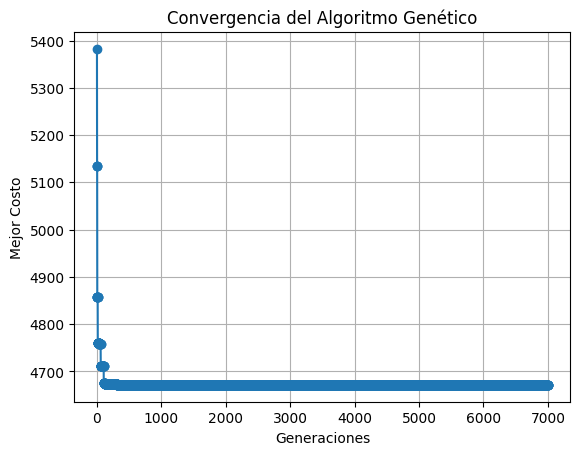

In [35]:
import matplotlib.pyplot as plt

plt.plot(historia_costos, marker='o')
plt.title("Convergencia del Algoritmo Genético")
plt.xlabel("Generaciones")
plt.ylabel("Mejor Costo")
plt.grid(True)
plt.show()

In [36]:
import folium
from folium import PolyLine, CircleMarker, Marker, Icon
from IPython.display import display
#graficar
locations = {0: (depot['Latitude'], depot['Longitude'])}
for i, row in clients_df.iterrows():
    locations[i+1] = (row['Latitude'], row['Longitude'])

latitudes = [lat for lat, lon in locations.values()]
longitudes = [lon for lat, lon in locations.values()]
center = [sum(latitudes)/len(latitudes), sum(longitudes)/len(longitudes)]
m = folium.Map(location=center, zoom_start=6)

colors = ['blue','green','purple','orange','darkred','cadetblue','darkgreen','black','pink','darkblue']


for idx, ruta in enumerate(mejor_solucion):
    color = colors[idx % len(colors)]
    ruta_completa = [0] + ruta + [0]
    print(f"Vehículo {idx+1}: Ruta -> {ruta_completa}")

    for i in range(len(ruta_completa) - 1):
        start = locations[ruta_completa[i]]
        end = locations[ruta_completa[i+1]]
        PolyLine([start, end], color=color, weight=3, opacity=0.8,
                 popup=f"V{idx+1}: {ruta_completa[i]} → {ruta_completa[i+1]}").add_to(m)

    for nodo in ruta:
        lat, lon = locations[nodo]
        demanda = client_demands[nodo - 1]
        CircleMarker((lat, lon), radius=5, color=color, fill=True,
                     fill_opacity=0.7,
                     popup=f"Cliente {nodo} Demanda: {demanda} kg").add_to(m)

folium.Marker(
    location=locations[0],
    icon=folium.Icon(color='red', icon='truck'),
    popup='Depósito (Puerto)'
).add_to(m)

display(m)

Vehículo 1: Ruta -> [0, 3, 11, 13, 1, 0]
Vehículo 2: Ruta -> [0, 4, 6, 5, 8, 12, 0]
Vehículo 3: Ruta -> [0, 2, 10, 7, 14, 9, 0]


#### Ventajas del Enfoque Metaheurístico

| Dimensión              | Ventaja clave                                         |
|------------------------|--------------------------------------------------------|
| Escalabilidad      | Puede extenderse fácilmente a 100+ clientes            |
| Flexibilidad       | Permite incorporar operadores personalizados           |
| Velocidad          | Tiempos de ejecución bajos incluso con muchas generaciones |
| Simplicidad        | No requiere formulaciones algebraicas complejas        |


#### Comparación con el Modelo Exacto

| Criterio                | Algoritmo Genético (GA)              | Modelo Exacto (Pyomo + GLPK)       |
|------------------------|--------------------------------------|-------------------------------------|
| Calidad de solución| Aproximada, cercana al óptimo        | Óptima garantizada                  |
| Tiempo de ejecución| Bajo incluso con poblaciones grandes | Alto en instancias medianas         |
| Robustez           | Depende de la semilla y configuración| Estable para una instancia dada     |
| Flexibilidad       | Alta para incorporar restricciones   | Baja: requiere redefinir el modelo  |


#### Conclusión

El algoritmo genético implementado en la Etapa 3 demostró ser una solución eficiente, flexible y adaptable para el problema de ruteo con capacidades. A pesar de no garantizar optimalidad, ofrece resultados competitivos en términos de costo y distribución geográfica, validando su utilidad práctica en entornos logísticos reales y escalables.